**02452** *Machine Learning*, Technical University of Denmark

- This Jupyter notebook contains exercises where you fill in missing code related to the lecture topic. *First*, try solving each task yourself. *Then* use the provided solution (an HTML file you can open in any web browser) as inspiration if needed. If you get stuck, ask a TA for help.

- Some tasks may be difficult or time-consuming - using the solution file or TA support is expected and perfectly fine, as long as you stay active and reflect on the solution.

- You are not expected to finish everything during the session. Prepare by looking at the exercises *before* the class, consult the TAs *during* class, and complete the remaining parts *at home*.

---

# Week 10: 	K-means and hierarchical clustering

**Content:**
- Part 1: K-means clustering
- Part 2: Cluster validity measures
- Part 3: K-means as data compression
- Part 4: Hierarchical Clustering
- Part 5: Clustering on the Old Faithful geyser dataset

**Objectives:**
- Understand the difference between supervised and unsupervised learning
- Understand the principles behind K-means and hierarchical clustering
- Understand how different linkage functions affects clustering types
- Compare clustering solutions using Rand index, Jaccard and NMI
- Evaluate clustering quality using class labels

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Algorithms
from sklearn.cluster import k_means
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn.metrics import rand_score, normalized_mutual_info_score

# Plotting style
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

# Helper functions
def gauss_2d(centroid, ccov, std=2, points=100):
    """
    Returns two vectors representing slice through gaussian, cut at given standard deviation.

    Parameters:
    centroid (array-like): The centroid of the Gaussian distribution.
    ccov (array-like): The covariance matrix of the Gaussian distribution.
    std (float, optional): The standard deviation at which to cut the Gaussian distribution. Default is 2.
    points (int, optional): The number of points to sample along the slice. Default is 100.

    Returns:
    tuple: A tuple containing two vectors representing the slice through the Gaussian distribution.
    """
    mean = np.c_[centroid]
    tt = np.c_[np.linspace(0, 2 * np.pi, points)]
    x = np.cos(tt)
    y = np.sin(tt)
    ap = np.concatenate((x, y), axis=1).T
    d, v = np.linalg.eig(ccov)
    d = std * np.sqrt(np.diag(d))
    bp = np.dot(v, np.dot(d, ap)) + np.tile(mean, (1, ap.shape[1]))
    return bp[0, :], bp[1, :]

def clusterplot(X, clusterid=None, centroids=None, y=None, covariances=None):
    
    if clusterid is not None:
        for i, pred_class in enumerate(np.unique(clusterid)):
            mask = (clusterid == pred_class)
            plt.scatter(X[mask, 0], X[mask, 1], s=100, facecolors=f'C{i}', label=f'Predicted class {pred_class}', linewidth=5)

    for i, true_class in enumerate(np.unique(y)):
        mask = (y == true_class)
        plt.scatter(X[mask, 0], X[mask, 1], s=50, c=f"C{i}", edgecolors='k', label=f'True class {true_class}')

    if centroids is not None:
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, marker='X')

    if covariances is not None:
        for i in range(len(centroids)):
            x1, x2 = gauss_2d(centroids[i], covariances[i])
            plt.plot(x1, x2, "-", color=f'C{i}', linewidth=3)

    plt.title("Cluster Plot")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(ncols=2)

def show_image(vec, resolution):
    img = vec.reshape(resolution)
    if resolution[0] == 1:
        img = np.squeeze(img)
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img.T)
    plt.axis("off")

def plot_compression(X, centroids, cluster_ids, resolution):
    # Initialize plot
    K = len(centroids)
    n_show = 5
    n_cols = 5
    n_rows = int(np.ceil(K / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.5 * n_cols, 2.5 * n_rows))
    fig.suptitle("Centroids", fontsize=16, weight="bold", y=1.02)

    # Plot centroids
    axes = axes.ravel()
    for i in range(K):
        plt.sca(axes[i])
        show_image(centroids[i], resolution)
        plt.title(f"Centroid {i}", fontsize=10)

    # Turn off any unused axes
    for j in range(K, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

    # Plot random faces and their centroids
    idxs = np.random.choice(len(cluster_ids), n_show, replace=False)
    fig, axes = plt.subplots(2, n_show, figsize=(2.5 * n_show, 5))
    fig.suptitle("Example faces and their nearest centroids", fontsize=16, weight="bold", y=1.02)

    for i, idx in enumerate(idxs):
        # Original image
        plt.sca(axes[0, i])
        show_image(X[idx], resolution)
        plt.title(f"Face #{idx}", fontsize=9)

        # Corresponding centroid
        plt.sca(axes[1, i])
        show_image(centroids[cluster_ids[idx]], resolution)
        plt.title(f"Centroid {cluster_ids[idx]}", fontsize=9)

    plt.tight_layout()
    plt.show()


---
## Introduction:
In previous exercises, we considered supervised learning, where we were provided with both input data $\boldsymbol{X}$ and corresponding target outputs $\boldsymbol{y}$. In classification tasks, these outputs were discrete labels, while in regression they were continuous values. The goal in supervised learning was to learn a mapping from $\boldsymbol{X}$ to $\boldsymbol{y}$ that generalizes well to unseen data.

We now move on to unsupervised learning, where only the input data $\boldsymbol{X}$ is available. Here, we do not have target outputs to guide the learning process. Instead, the goal is to uncover hidden structure within the data - for example, by identifying groups of observations that share similar characteristics. This process is known as clustering.

We will explore two fundamental clustering methods: k-means clustering and hierarchical clustering. Through these exercises, you will gain a deeper understanding of how unsupervised learning methods discover structure in data, how to interpret clustering results, and how to evaluate clustering quality both with and without reference labels.


---
## Part 1: K-means clustering

In this part of the exercise we will investigate k-means clustering. 

In k-means, we start by initializing $K$ cluster centers. Each of the data points are assigned to the cluster in closest proximity, according to some measure of distance. When the distance is given by the squared Euclidean distance, the centers are commonly denoted centroids. 

Once the data points have been assigned to a cluster, we update each cluster center to be placed at the center of the data points that are assigned to that cluster. This continues iteratively, usually until the assignment of data points to centers no longer change or until a maximal number of iterations is reached. 

An example gif is shown below:

<div style="display: flex; justify-content: center; align-items: center; gap: 20px;">
  <img src="kmeans_illustration_loop.gif" alt="K-means Illustration" style="width: 25%;">
  <img src="kmeans_pseudocode.png" alt="K-means Pseudocode" style="width: 25%;">
</div>


In the following, we will cluster a simple synthetic dataset, located in `data/synth1.csv` using the k-means algorithm.

**Task 1.1:** Load the data into a dataframe, inspect it, and split it into $\left(\boldsymbol{X}, \boldsymbol{y}\right)$. 

**Task 1.2:** Use the `clusterplot(X=X, y=y)`-function to visualize the dataset. 

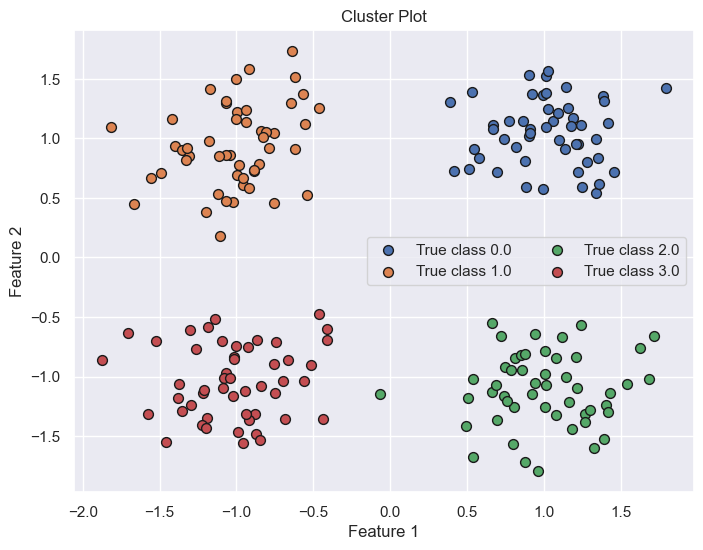

In [36]:
dataset_name = "synth1.csv"

# 1.1) Load the data
df = pd.read_csv(r'C:/Users/mrusn/PycharmProjects/02452_Machine_Learning/Lecture_10/data/' + dataset_name)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
# 1.2) Visualize the data with clusterplot
plt.figure(figsize=(8, 6))
clusterplot(X, y=y)
plt.show()

**Task 1.3:** Considering the scattered points, how many centroids should we initialize our K-means algorithm with? Are there any points that seem like they might be difficult to assign correctly?

We will now assign each point to a cluster using the K-means algorithm. 

**Task 1.4:** Run the K-means algorithm on the synthetic data, using the `k_means` function from `sklearn.cluster`.
> *Hint:* Save the outputs as `centroids, cluster_ids, _`. The last output is not needed here, hence the `_`.

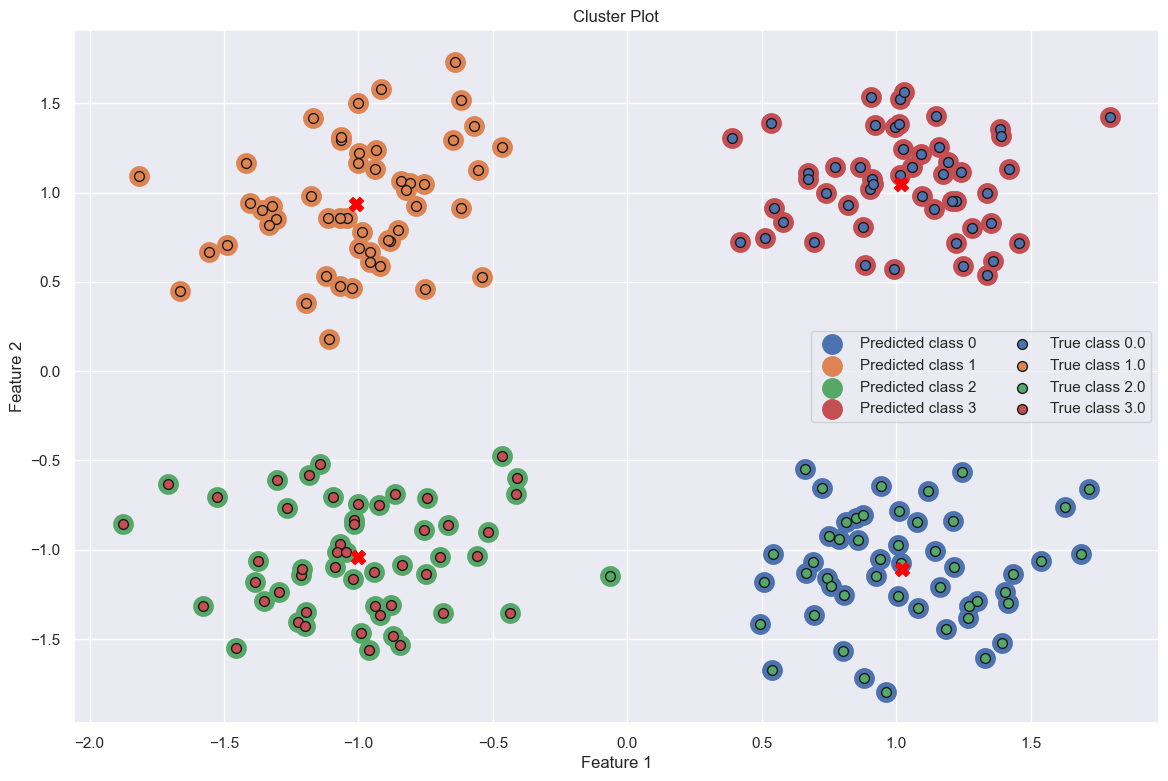

In [37]:
# Number of clusters:
K = 4

# K-means clustering:
centroids, cluster_ids, _ = k_means(X, n_clusters = K, random_state=0, n_init="auto")


# Plot results:
plt.figure(figsize=(14, 9))
clusterplot(X=X, clusterid=cluster_ids, centroids=centroids, y=y)
plt.show()

**Task 1.5:** Do the cluster assignments correspond to the original true classes? Does that matter?
- *Answer:*
They do not correspond to the original classes, but beside one point, at least they are clustered correctly. But given that each class corespond to some specific group, it matters and leaving it like this might gave out missinformations.
- 
> *Hint:* Think of what we're trying to do in terms of what you have learned about supervised / unsupervised methods. 

**Task 1.6:** Try running the above code-blocks on the other synthetic datasets, `synth2`, `synth3` and `synth4`. Why might some of these perform badly when using K-means with a euclidean distance metric?


--- 
## Part 2: K-means as data compression (Optional)

K-means clustering has many different applications, one of which is data compression. A data set can be compressed by performing k-means clustering and then representing each data object by its cluster center. Thus, the only data that need to be stored is the $K$ cluster centers and the $N$ cluster indices.

We will now consider a subset of the wild faces dataset described [here](https://osf.io/6p4r7/overview). 
Each data object is a $40 \times 40 \times 3 = 4800$ dimensional vector, corresponding to an image of $40 \times 40$ pixels, with $3$ color channels each. 

**Task 2.1:** Load the Wild Faces dataset from `data/wildfaces.csv`.
> *Hint:* Extract the data into `X` by using `df.values`.

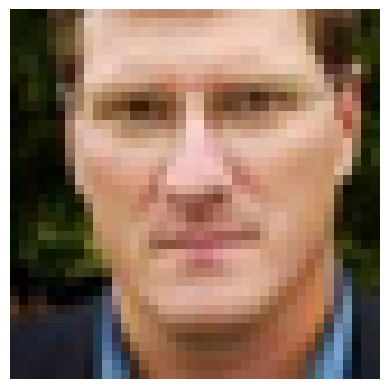

In [59]:
# 2.1) Load the Wild Faces dataset from data/wildfaces.csv
df = pd.read_csv(r'C:\Users\mrusn\PycharmProjects\02452_Machine_Learning\Lecture_10\data\wildfaces.csv')
X = df.values


# Image resolution
resolution = (3, 40, 40) # (color-channels, height, width)

# Show image example
show_image(X[0], resolution)

The following code block computes a k-means clustering of the data with K = 10 clusters. Then plots the centroids as images, as well as 5 random images from the data set as well as their corresponding cluster centroids.

**Task 2.2:** How well is the data represented by the cluster centroids? Are you able to recognize the faces in the compressed representation? What happens if you increase or decrease the number of clusters?

At low centroids, the representation is pretty bad. You can recognize the faces but not the face features. As you increase the number of centroids, the image sharpens and the closest images to the random 5 images are themselves.

If I reduce number of centroids to 10 I can only have 10 specific colours in my image -> compared to original 40x40, where each pixel has it's own colour (comprising of RGB channels). So each pixel is group to its closest neighbour based on their colour. 

As I increase number of centroids, I am increasing number of groups where each group can take a unique color. This increases the resolution of the picture.

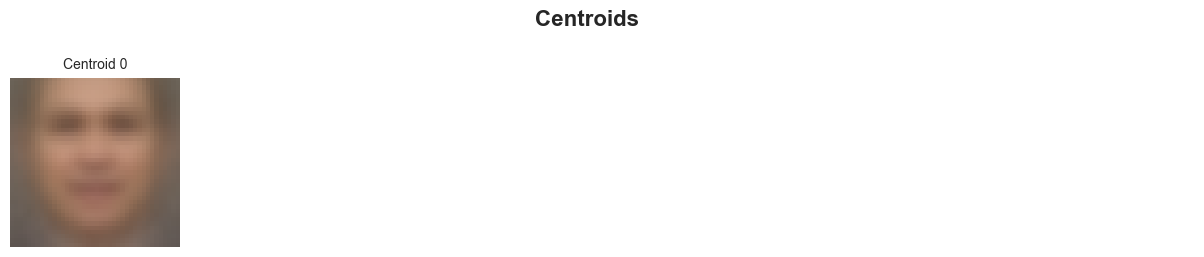

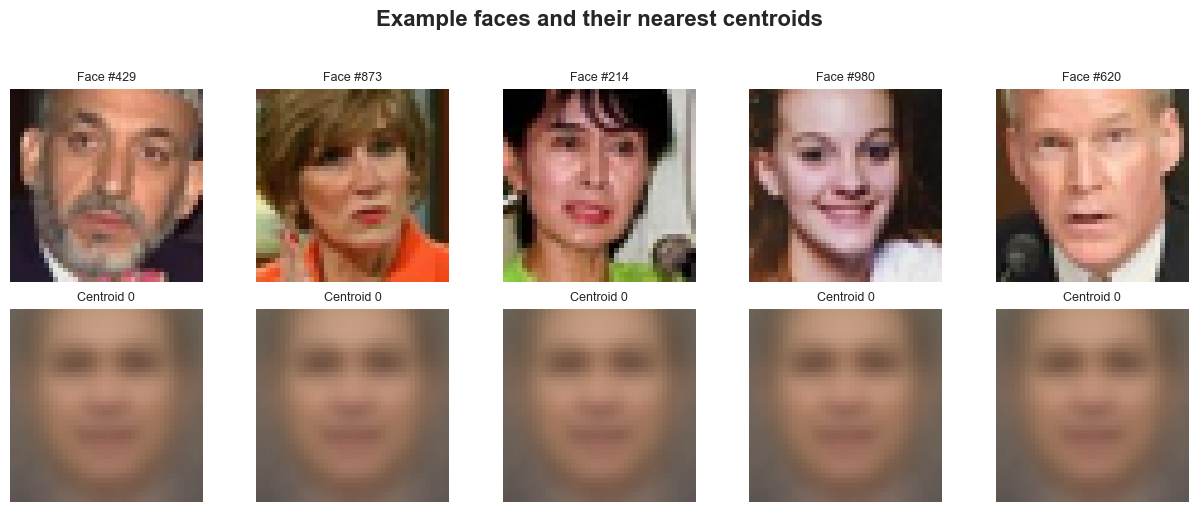

In [53]:
# Run K-means clustering
K = 1
centroids, cluster_ids, _ = k_means(X, K, verbose=False, max_iter=100, n_init=1)

plot_compression(X, centroids, cluster_ids, resolution)

**Task 2.3:** Load the digits dataset instead (`data/digits.npy`).
> *Hint:* The last column represents the label, `y`, you can disregard this when loading into `X`.

> *Hint:* Each data object is a $16\cdot 16=256$ dimensional vector, corresponding to a gray scale $16\times 16$ pixels image - what is the `resolution` in this case?

**Task 2.4:** Why does running k-means with $K=10$ not give you 10 clusters corresponding to the $10$ digits $0 \dots 9$? How many clusters do you need to visually represent the 10 different digits? Are there any digits that the clustering algorithm seems to confuse more than others?


---
## Part 3: Cluster validity measures

Previously, we have evaluated our supervised learning methods in terms of error rate and accuracy. This however, requires that we can match the estimated outcome to the true underlying classes, provided they are known. 

Even when we know the true underlying classes, we do not in genereal know which cluster corresponds to which class, just like we've seen above. The true classes and the estimated clusters would ideally relate to eachother however - one way of relating the two, is to find out which cluster best matches each class, such that each class is assigned one of the clusters, and then calculate the error rate. 

**Task 3.1:** Is the above definition of the classification error rate for clustering reasonable if we extract the same number of clusters as classes in the data? Does the definition of the classification error make sense when the number of extracted clusters are different from the true underlying classes?

- *Answer:*

### Validity Measures

Rather than using the typical error rate, we will consider the supervised measures of *cluster validity*, in particular the Rand Index, Jaccard Similarity and normalized mutual information (NMI). 

When we want to compare two clustering partitions, $Q$ and $Z$, we can compare their similarity by looking at pairs of observations. For every pair of points $(i, j)$, we check whether they are placed in the same or in different groups in $Z$ and $Q$.

We define:

$$
S = \{\text{Number of pairs in the same cluster in both } Z \text{ and } Q\}
$$

$$
D = \{\text{Number of pairs in different clusters in both } Z \text{ and } Q\}
$$

The total number of unique pairs is $\frac{1}{2} N (N-1)$, where $N$ is the number of data points.

The **Rand Index** measures the overall agreement between the two clustering partitions, and is thus defined as:

$$
R(Z, Q) = \frac{S + D}{\frac{1}{2}N(N-1)}
$$

A problem with the Rand index is that if there are many clusters, there will typically be many more pairs of observations in different clusters than in the same cluster and so in general we can expect $D \gg S$ which means the Rand index is often close to 1. Another measure is therefore the Jaccard similarity, which disregards the pairs in different clusters, $D$.

I.e. The **Jaccard similarity** measures agreement, but focuses only on the pairs that are placed *together* in at least one of the partitions (it ignores pairs that are in different clusters in both), and is therefore defined as:

$$
J(Z, Q) = \frac{S}{\frac{1}{2}N(N-1) - D}
$$

While the Rand and Jaccard indices are based on pair counting, **Normalized Mutual Information** is based on information theory.  
It measures how much information one clustering partition provides about the other.

To compute this, we first define the joint probability that an observation is assigned to cluster $k$ in partition $Z$ and to cluster $m$ in partition $Q$:

$$
p_{km}(k, m) = \frac{n_{km}}{N}, \quad \text{for } k = 1, \ldots, K \text{ and } m = 1, \ldots, M
$$

where $n_{km}$ is the number of observations that belong to cluster $k$ in $Z$ and cluster $m$ in $Q$.

From this joint distribution, we can compute the marginal distributions:

$$
p_k(k) = \sum_{m=1}^M p_{km}(k, m), \quad p_m(m) = \sum_{k=1}^K p_{km}(k, m)
$$

The entropy of the distributions measures the complexity of the cluster assignments.
For a single clustering $Z$, the entropy is:

$$
H[Z] = -\sum_{k=1}^K p_k(k) \log p_k(k)
$$

Similarly, the joint entropy of the two partitions is:

$$
H[Z Q] = -\sum_{k=1}^K \sum_{m=1}^M p_{km}(k, m) \log p_{km}(k, m)
$$

The *mutual information* between $Z$ and $Q$ measures the amount of information shared between the two clusterings - that is, how much knowing one reduces uncertainty about the other:

$$
\mathrm{MI}[Z, Q] = H[Z] + H[Q] - H[Z Q]
$$

Finally, the **Normalized Mutual Information (NMI)** scales this value to lie between 0 and 1, making it easier to interpret and compare across datasets:

$$
\mathrm{NMI}[Z, Q] = \frac{\mathrm{MI}[Z, Q]}{\sqrt{H[Z] , H[Q]}}
$$

**Task 3.2:** Fill in the missing pieces in the function below to calculate the three validity measures.
> *Hint:* There are many additional validity measures, check `sklearn.metrics.cluster` - you're welcome to implement more measures:)

In [34]:
def clusterval(Q, Z):
    # --- Rand index and Jaccard similarity ---
    S, D = 0, 0
    N = len(Q)
    for i in range(N):
        for j in range(i):
            # Pair i,j belong to same cluster for both Q and Z
            if Q[i] == Q[j] and Z[i] == Z[j]:
                S += 1
            # Pair i,j belong to different clusters for both Q and Z
            if Q[i] != Q[j] and Z[i] != Z[j]:
                D += 1
    
    # 3.2) Compute rand index and jaccard similarity from S, D and N
    unique_pairs = 1/2 * N * (N - 1)
    rand = (S + D) / unique_pairs
    jaccard = S / (unique_pairs - D)
    

    # --- NMI ---
    # Build contingency table n_km
    labels_Z = np.unique(Z)
    labels_Q = np.unique(Q)
    K = len(labels_Z)
    M = len(labels_Q)
    n_km = np.zeros((K, M))

    # Fill contingency table
    for i, k in enumerate(labels_Z):
        for j, m in enumerate(labels_Q):
            n_km[i, j] = np.sum((Z == k) & (Q == m))

    # Convert to joint probability distribution p_km
    p_km = n_km / N
    # Marginals
    p_k = np.sum(p_km, axis=1)
    p_m = np.sum(p_km, axis=0)

    # Entropy function
    def H(p):
        EPS = 2.2e-16
        return -np.sum(p * np.log(p + EPS))

    H_Z = H(p_k)
    H_Q = H(p_m)
    H_ZQ = H(p_km)

    # 3.2) Compute mutual information and normalized MI from H_Z, H_Q, H_ZQ
    MI_ZQ = H_Z + H_Q - H_ZQ
    NMI = MI_ZQ / (np.sqrt(H_Z)*np.sqrt(H_Q))

    return rand, jaccard, NMI

In the following, we evaluate how the clustering quality changes as we vary the number of clusters $K$.
For each value of $K = 2, \ldots, 10$, we perform K-means clustering on the synthetic dataset $\boldsymbol{X}$, and then compare the resulting cluster partitions to the true class labels $\boldsymbol{y}$ using the three cluster validity measures introduced above: **Rand Index**, **Jaccard Similarity**, and **Normalized Mutual Information (NMI)**.

The results are stored in dictionaries and plotted to visualize how well the clustering aligns with the true labels as the number of clusters increases.

**Task 3.3:** Compute the cluster validities in the loop, and store the scores in the provided dictionaries. 
> *Hint:* If you tried running the previous exercises on the different synthetic datasets, make sure to load `synth1` again for this exercise.

In [71]:
# Load synthetic dataset again
dataset_name = "synth1"
df = pd.read_csv(f"data/{dataset_name}.csv")
display(df.head())
# Separate features and target
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

,Attribute A,Attribute B,Class
0,0.418193,0.725060,0.0
1,1.160776,1.253722,0.0
2,0.991951,0.573326,0.0
3,1.059111,1.143922,0.0
4,0.866616,1.143537,0.0


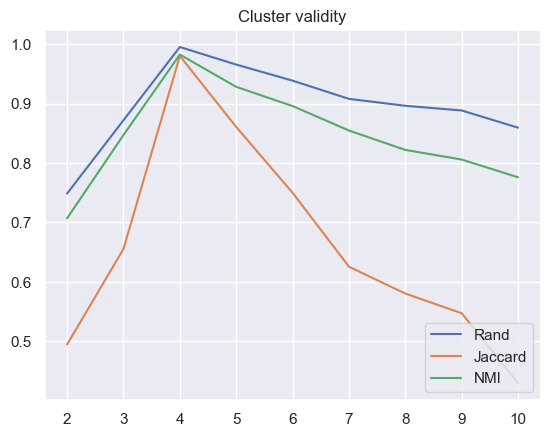

In [72]:
# Maximum number of clusters:
K = 10

# Allocate variables:
Rand, Jaccard, NMI = {}, {}, {}

# Run clustering for K=2,...,10
for k in range(2, K+1):
    # run K-means clustering:
    centroids, cluster_ids, _ = k_means(X, k, random_state=3)
    # 3.3) compute cluster validities between true labels y and cluster_ids - insert outputs into Rand, Jaccard, NMI dictionaries
    Rand[k], Jaccard[k], NMI[k] = clusterval(y, cluster_ids)

# Plot results:
plt.figure(1)
plt.title('Cluster validity')
plt.plot(Rand.keys(), Rand.values())
plt.plot(Jaccard.keys(), Jaccard.values())
plt.plot(NMI.keys(), NMI.values())
plt.legend(['Rand', 'Jaccard', 'NMI'], loc=4)
plt.show()


**Task 3.4:** How can the cluster validity measures be used to select the best number of clusters?
- *Answer:*

- We pick the one with the highest simmilarity measure.

**Task 3.5:** What happens when more than four clusters are used to model the data?
> *Hint:* Go back to **Task 1.4** and change `K` if you want to see the cluster partitions with different $K$.
>
> We are overfitting the model

For supervised learning we used cross-validation to evaluate performance and estimate the number of parameters in our models, i.e., the number of clusters. Let us assume that we split the data into a training and a test set, train the k-means model on the training set and evaluate how well the model accounts for the test data. Consider evaluating the clustering by summing the distance of test points to the closest estimated cluster center obtained. 

**Task 3.6:** What do you think will happen with the training and test error as we increase the number of clusters?
- *Answer:*

- Training error decreases as each point will be closer to some centroid - we can achieve zero if we have as many centroids as datapoints. But at some point we will overfit our model. The test error decreases at first as we approach to the number of centroids that equals number of classes, but then it start increases as predicted class won't match the true class.


---
## Part 4: Hierarchical Clustering

In this part of the exercise, we will explore agglomerative hierarchical clustering.

In agglomerative clustering, we start by treating each data point as its own individual cluster. The algorithm then proceeds bottom-up, repeatedly merging the two clusters that are most similar to each other according to a chosen distance measure.

At each step, the distance between clusters can be defined in several ways, through *linkages* — for example:

- Minimum (Single) linkage: distance between the closest pair of points in the two clusters.

- Maximum (Complete) linkage: distance between the farthest pair of points.

- Group average linkage: average distance between all pairs of points across clusters.

This merging process continues until all data points belong to a single cluster, forming a hierarchy of nested clusterings. The result is often visualized using a dendrogram, which shows how clusters are combined at different distance thresholds.

An example gif is shown below:

<div style="display: flex; justify-content: center; align-items: center;">
  <img src="hierarchical_clustering_illustration.gif"
       alt="Hierarchical Clustering Illustration"
       style="width: 50%;">
</div>

We will once again load the `synth1` dataset.

In [24]:
# Load synth1 data and perform hierarchical clustering
dataset_name = "synth1"

# Load the data
df = pd.read_csv(f"data/{dataset_name}.csv")
display(df.head())

# Separate features and target
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

,Attribute A,Attribute B,Class
0,0.418193,0.725060,0.0
1,1.160776,1.253722,0.0
2,0.991951,0.573326,0.0
3,1.059111,1.143922,0.0
4,0.866616,1.143537,0.0


**Task 4.1:** Implement the linkage function below, to perform hierarchical clustering with Single linkage and a euclidean distance metric. 
> *Hint:* Use `Z = linkage(X, method, metric)`.

**Task 4.2:** Use `fcluster(Z, criterion="maxclust", t=n_max_clusters)` to assign cluster_ids to the points. Why do we need to set a threshold on the amount of clusters?  
- *Answer:*
> *Hint:* How many clusters are left at the end of the hierarchical clustering algorithm?

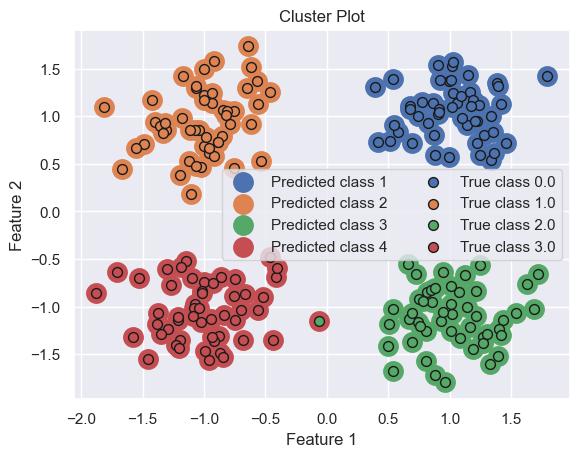

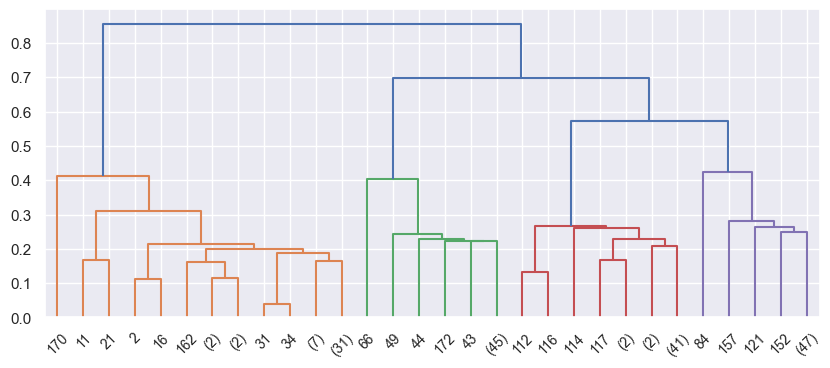

In [25]:
# 4.1) Perform hierarchical/agglomerative clustering on data matrix - with Single linkage and Euclidean distance
metric = 'euclidean'
method = 'single'
Z = linkage(X, method, metric)

# 4.2) Compute cluster ids by thresholding the dendrogram
n_max_clusters = 4
cluster_ids = fcluster(Z, criterion="maxclust", t=n_max_clusters)

plt.figure(1)
clusterplot(X, clusterid=cluster_ids, y=y) 
# Display dendrogram
max_display_levels = 6
plt.figure(2, figsize=(10, 4))
dendrogram(
    Z, truncate_mode="level", p=max_display_levels, color_threshold=Z[-n_max_clusters + 1, 2]
)

plt.show()

**Task 4.3:** Try changing the linkage method and see how it changes the dendrogram. 



**Task 4.4:** Try running your code several times to see if it generates exactly the same dendrogram each time?
> *Hint:* Why might this be different from the k-means algorithm?

**Task 4.5:** Try to use the other synthetic datasets, `synth2`, `synth3` and `synth4`. Can you find suitable distance measures for these?


---
## Part 5: Clustering on the Old Faithful geyser dataset

Old Faithful is a famous geyser located in Yellow Stone national park in the US.

The Old Faithful geyser dataset originally described in *Härdle, W. (1991) Smoothing Techniques with Implementation in S. New York*, consists of $N = 272$ observations of two variables, namely the duration of each eruption in minutes (duration) and the waiting time between eruptions also in minutes (waiting). The geysers are categorized as $0 = \text{small}$ and $1 = \text{large}$.

**Task 5.1:** Load the Old Faithful dataset, found in `data/faithful.csv`, into ($\boldsymbol{X}$, $\boldsymbol{y}$).
> *Hint:* Load `duration` and `waiting` into `X`.

**Task 5.2:** Plot the data using `clusterplot`.

   duration  waiting  y  Class
0     3.600     79.0  1  large
1     1.800     54.0  0  small
2     3.333     74.0  1  large
3     2.283     62.0  0  small
4     4.533     85.0  1  large


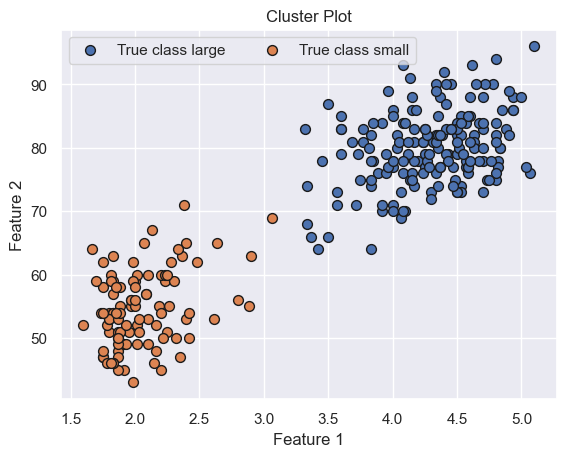

In [30]:
# 5.1) Load /data/faithful.csv
df = pd.read_csv(r'C:\Users\mrusn\PycharmProjects\02452_Machine_Learning\Lecture_10\data\faithful.csv')
print(df.head())
X = df.drop(columns = ['Class']).values
y = df['Class'].values
# 5.2) Plot the data using clusterplot
clusterplot(X, y=y) 

# We will now do clustering on the dataset, we will start with K-means.

**Task 5.3:** Run K-means on the dataset, and plot the points with their corresponding cluster ids and centroids. 

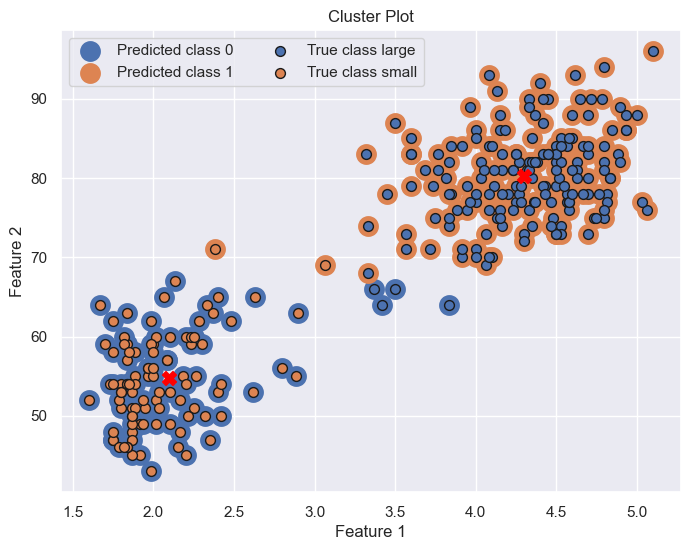

In [31]:
# 5.3) Run K-means on the dataset, and plot the points with their corresponding cluster ids and centroids.
# Cluster with k-means
K = 2
centroids, cluster_ids, _ = k_means(X, K, n_init=1)
plt.figure(figsize=(8, 6))
clusterplot(X, clusterid=cluster_ids, centroids=centroids, y=y)
plt.show()

**Task 5.4:** Run the `clusterval`-function you created in **Task 3.2** on your cluster ids, to determine the cluster validity measures. 

In [35]:
# 5.4) Run the `clusterval`-function you created in **Task 3.2** on your cluster ids, to determine the cluster validity measures.
Rand, Jaccard, NMI = clusterval(y, cluster_ids)
print(f"Rand index: {Rand:.4f}, Jaccard similarity: {Jaccard:.4f}, NMI: {NMI:.4f}")

Rand index: 0.9567, Jaccard similarity: 0.9223, NMI: 0.8416


**Task 5.4:** What happens if you increase $K$ beyond the obvious $K=2$? Try to run the program a couple of times (resulting in different initial conditions). Do you see the same solution every time?  

The scaling of the variables can seriously affect the results we get in clustering.

**Task 5.5:** Discuss whether it is more reasonable to normalize the Old faithful data set? 
- *Answer:*

**Task 5.6:** Try normalizing the data and see whether the results of running `k-means` change.
> *Hint:* Use `StandardScaler` from `sklearn.preprocessing` to normalize the data. 

We now move on to hierarchical clustering. 

**Task 5.7:** Run hierarchical clustering on the Old Faithful data using the `single` and `ward` linkage, with and without normalizing the data. Plot the clusterplots and the dendrograms - do you find support for a two cluster model from the structure of the dendrograms?

**Task 5.8:** Add the `clusterval`-function to your plots

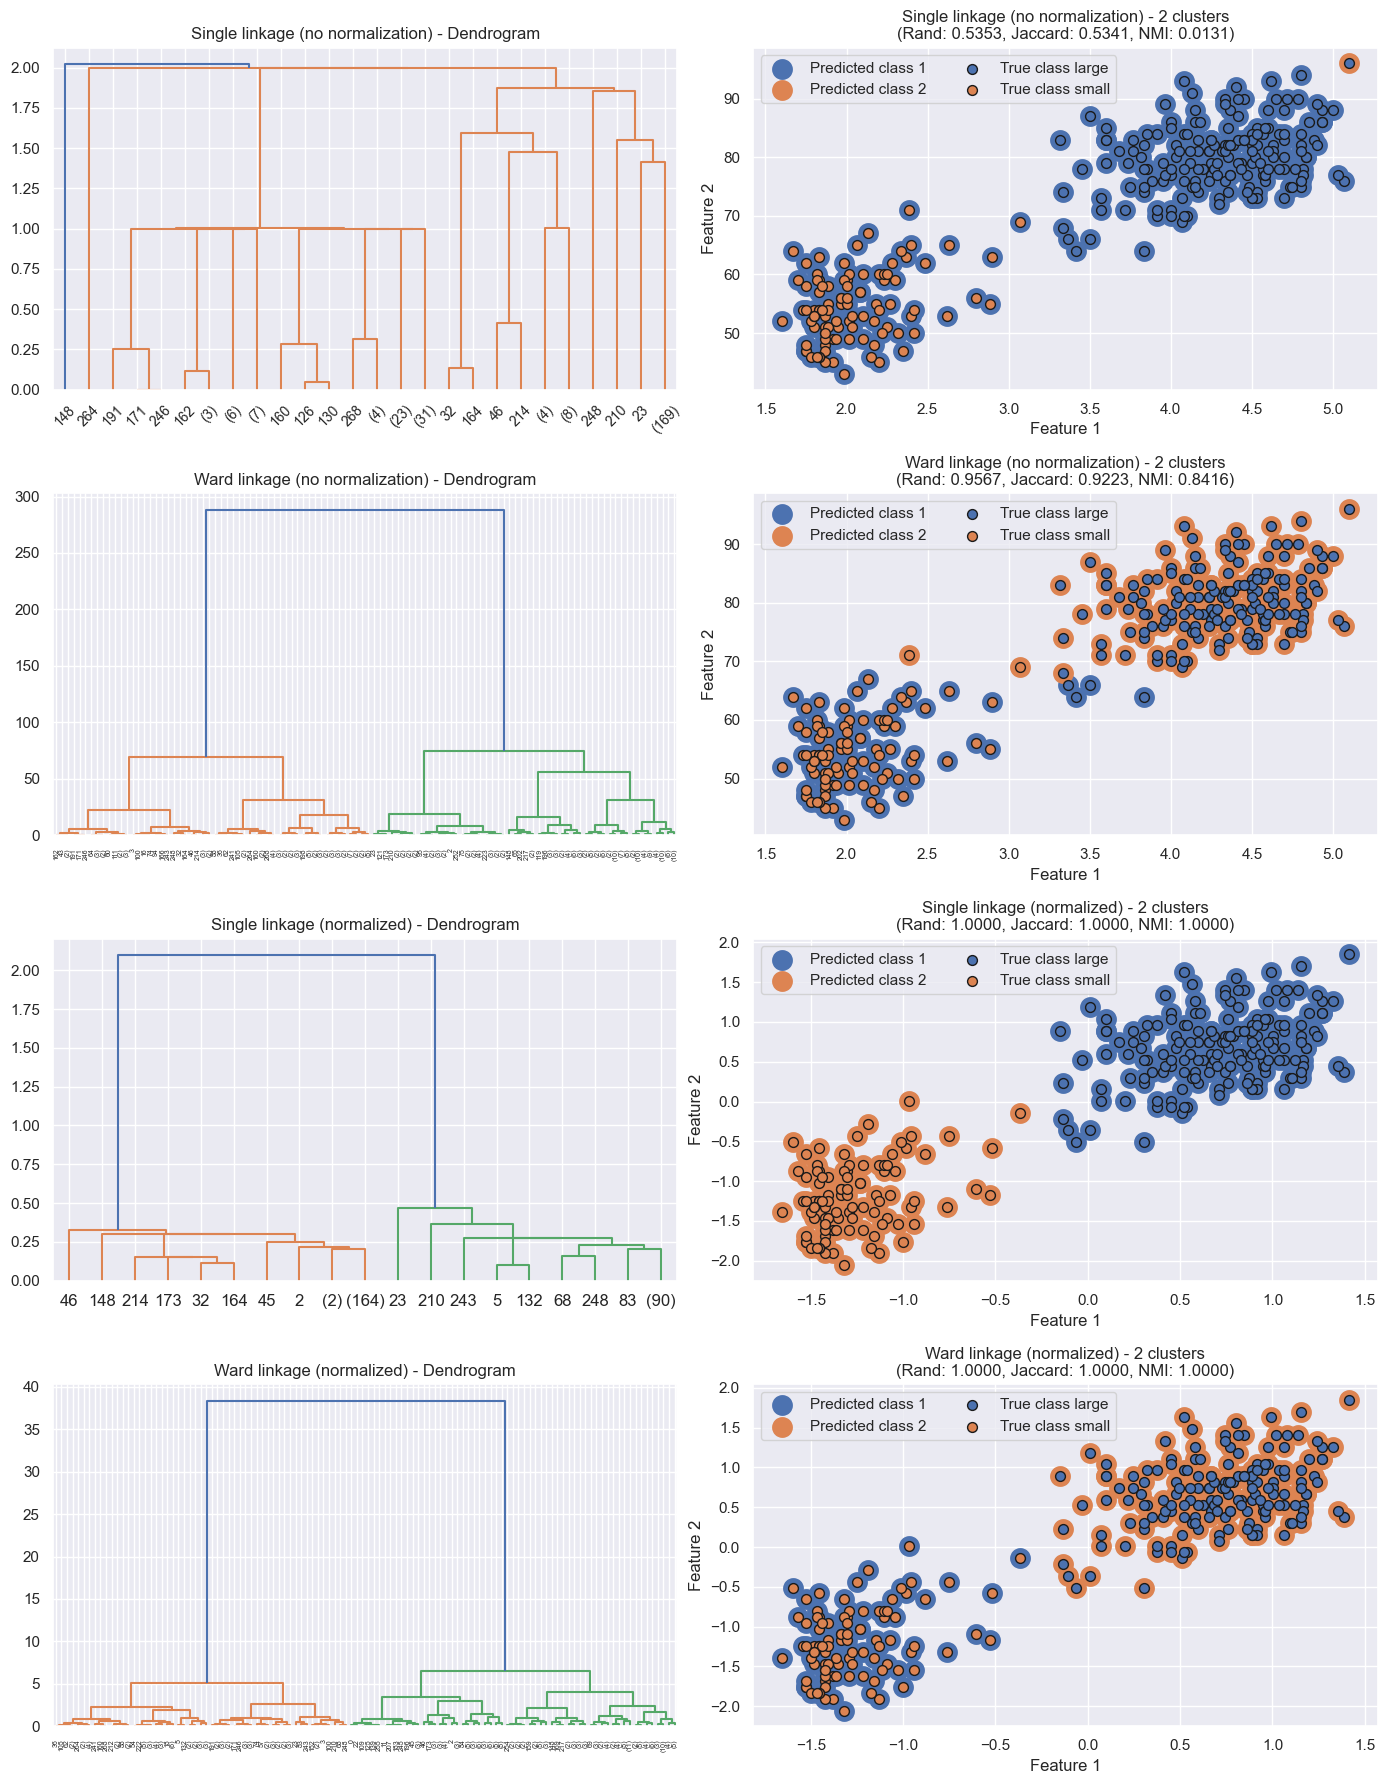

In [36]:
# 5.7) Perform hierarchical clustering with and without normalization, using both Single and Ward linkages. 
# Plot dendrograms and cluster plots for each configuration.
from sklearn.preprocessing import StandardScaler

n_max_clusters = 2

# --- Compute linkage ---

# Without normalization
Z_single = linkage(X, method="single", metric="euclidean")
Z_ward = linkage(X, method="ward")

# With normalization
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
Z_single_norm = linkage(X_norm, method="single", metric="euclidean")
Z_ward_norm = linkage(X_norm, method="ward")

# --- Prepare the figure ---
fig, axes = plt.subplots(4, 2, figsize=(14, 18))
plt.subplots_adjust(hspace=0.4, wspace=0.25)

# Each row = one configuration: (dendrogram, cluster plot)
configs = [
    (Z_single, X, "Single linkage (no normalization)"),
    (Z_ward, X, "Ward linkage (no normalization)"),
    (Z_single_norm, X_norm, "Single linkage (normalized)"),
    (Z_ward_norm, X_norm, "Ward linkage (normalized)"),
]

for i, (Z, X_used, title) in enumerate(configs):
    # Dendrogram (left column)
    dendrogram(
        Z,
        truncate_mode="level",
        p=6,
        color_threshold=Z[-n_max_clusters + 1, 2],
        ax=axes[i, 0]
    )
    axes[i, 0].set_title(f"{title} - Dendrogram")

    # Cluster plot (right column)
    cluster_ids = fcluster(Z, criterion="maxclust", t=n_max_clusters)
    plt.sca(axes[i, 1])  # switch active axes
    clusterplot(X_used, clusterid=cluster_ids, y=y)
    # 5.8) Add the `clusterval`-function to your plots
    clusterval_scores = clusterval(y, cluster_ids)
    plt.title(f"{title} - {n_max_clusters} clusters\n(Rand: {clusterval_scores[0]:.4f}, Jaccard: {clusterval_scores[1]:.4f}, NMI: {clusterval_scores[2]:.4f})")

plt.tight_layout()
plt.show()

**Task 5.8:** Explain why it is so important to normalize the data when using Single linkage on this dataset? Relate your answer to your understanding of the different linkage methods. 
- *Answer:*